## 세팅

In [7]:
import matplotlib.pyplot as plt
from utils.utils import *

train_list = glob.glob(os.path.join('data/train', '*.jpg'))
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_data = dataset(train_list, transform=transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=4, shuffle=True)

images, labels = next(iter(train_loader))

## 이미지 확인


--------------------before CutMix--------------------



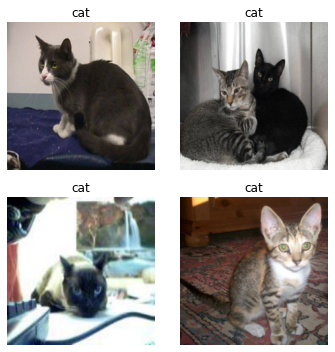

In [8]:
print('\n'+'-'*20 + 'before CutMix' + '-'*20 + '\n')
plt.figure(figsize=(5, 5))
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title('dog' if labels[i] else 'cat')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 바운더리 박스 샘플링

### 람다 샘플링

In [9]:
lmbda = stats.beta(1, 1).rvs(1)[0]
print("람다:", lmbda)

람다: 0.7728321726456837


### 패치 너비, 높이 계산

In [10]:
image_height = images[0].size()[-2]
image_width = images[0].size()[-1]
cut_ratio = np.sqrt(1 - lmbda)
print("패치 비율:", cut_ratio)
patch_width = np.int(image_height * cut_ratio)
print("패치 너비:", patch_width)
patch_height = np.int(image_width * cut_ratio)
print("패치 높이:", patch_height)

패치 비율: 0.47662126196207016
패치 너비: 106
패치 높이: 106


### 패치 중심위치 샘플링

In [11]:
center_x = np.random.randint(image_width)
print("패치 중심 x:", center_x)
center_y = np.random.randint(image_height)
print("패치 중심 y:", center_y)

패치 중심 x: 221
패치 중심 y: 47


### 바운더리 박스 계산

In [12]:
boundary_x1 = np.clip(center_x - patch_width // 2, 0, image_width)
boundary_x2 = np.clip(center_x + patch_width // 2, 0, image_width)
boundary_y1 = np.clip(center_y - patch_height // 2, 0, image_height)
boundary_y2 = np.clip(center_y + patch_height // 2, 0, image_height)

print(f"바운더리 박스:", (boundary_x1, boundary_x2, boundary_y1, boundary_y2))

바운더리 박스: (168, 224, 0, 100)


### 람다 조정

In [13]:
adjusted_lmbda = 1 - ((boundary_x2 - boundary_x1) * (boundary_y2 -
                      boundary_y1)) / (images.size(-1) * images.size(-2))
print("수정 후 람다:", adjusted_lmbda)

수정 후 람다: 0.8883928571428571


## 이미지 셔플

In [14]:
random_idx = np.random.permutation(images.size(0))
print("원래 index:", [0, 1, 2, 3])
print("섞인 index:", list(random_idx))
print()
shuffled_labels = labels[random_idx]
print("원래 labels:", labels)
print('섞인 labels:', shuffled_labels)
new_patches = images[random_idx, :,
                     boundary_y1:boundary_y2, boundary_x1:boundary_x2]

원래 index: [0, 1, 2, 3]
섞인 index: [3, 1, 0, 2]

원래 labels: tensor([0, 0, 0, 0])
섞인 labels: tensor([0, 0, 0, 0])


## 시각화

### Sampled Patches


--------------------Old & New Patches--------------------



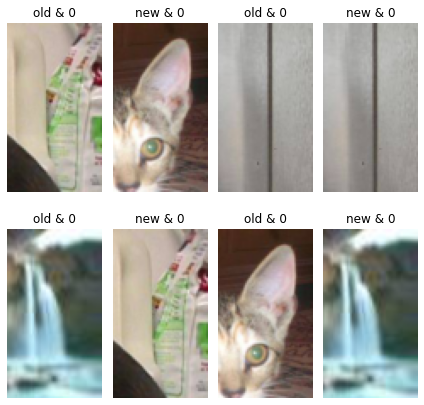

In [15]:
print('\n'+'-'*20 + 'Old & New Patches' + '-'*20 + '\n')
pairs = list(zip(images[:, :, boundary_y1:boundary_y2,
             boundary_x1:boundary_x2], new_patches))
pairs_labels = list(zip(labels, shuffled_labels))
plt.figure(figsize=(6, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    if i % 2 == 0:
        plt.imshow(pairs[i//2][0].permute(1, 2, 0))
        plt.title(f'old & {pairs_labels[i//2][0]}')
    else:
        plt.imshow(pairs[i//2][1].permute(1, 2, 0))
        plt.title(f'new & {pairs_labels[i//2][1]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### After CutMix

#### Paste Patches

In [16]:
images[:, :, boundary_y1:boundary_y2, boundary_x1:boundary_x2] = new_patches

#### Visualization


--------------------after CutMix--------------------

------------lambda : 0.8883928571428571------------


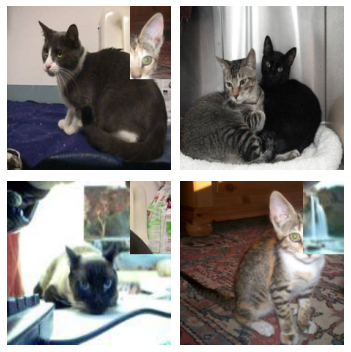

In [17]:
print('\n'+'-'*20 + 'after CutMix' + '-'*20 + '\n')
print('-'*12 + f'lambda : {adjusted_lmbda}' + '-'*12)
plt.figure(figsize=(5, 5))
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()

## Appendix: Loss Function

In [ ]:
outputs = net(images)

#loss = criterion(outputs, labels)

loss = criterion(outputs, labels) * adjusted_lmbda + \
    criterion(outputs, shuffled_labels) * (1 - adjusted_lmbda)